##### [과제] 산탄데르 고객 만족 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측을 수행하세요. 단, 성능개선을 위한 튜닝 및 중요 변수들에 대한 시각화 포함

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('./dataset/santander/train_santander.csv', encoding ='latin1')
print('dataset shape:', cust_df.shape)
cust_df.head()
# 클래스 값 컬럼을 포함한 피처가 371개 존재함

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [11]:
# 111 개의 float타입, 260개의 int형 타입 -> 모두 숫자형, Null값은 없다
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [16]:
print(cust_df['TARGET'].value_counts()) # 구성 요소 확인
# tartget이 1이면 불만 0이면 만족
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count() # 불만인 고객 카운팅
total_cnt = cust_df.TARGET.count() 
# 불만족 비율 -> 불만족 개수 / 전체 개수 
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))
# 불만족 고객은 얼마 되지 않는 4%에 불과함

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [17]:
# DataFrame의 describe()메서드를 이용해 각 피처의 값 분포를 간단히 확인
cust_df.describe()
# var3컬럼의 경우 min 값이 -999999임 -> NaN이나 특정 예외 값을 -999999로 변환했을 것이다.

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [18]:
print(cust_df.var3.value_counts()[:10]) # value_counts는 특정 컬럼의 개별적인 값의 빈도를 알 수 있다

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [ ]:
cust_df['var3'].replace(-999999,2,inplace=True) # 999999를 2로 대체하고 원본반영시킴 -> 2가 가장 빈도수가 많으니까
cust_df.drop('ID', axis=1, inplace=True) # ID 피처는 단순 식별자에 불과하므로 피처를 드롭시킴

In [24]:
# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1] # target만 제외시킴 -> 열 맨끝만 제외
y_labels = cust_df.iloc[:,-1] # 열 하나만 -> target만 선택
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [27]:
# 학습과 성능 평가를 위해 원본 데이터에서 -> 학습 데이터 테스트 데이터를 분리함
# 비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0},  테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369),  테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [36]:
# XGBoost 학습 모델 생성 예측 결과를 ROC AUC로 평가
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# eval_metric -> 성능 평가 지표를 acu로, early_stopping_rounds-> 조기 중단 파라미터는 100으로 설정하고 학습 수행
# eval_set -> 성능 평가를 수행할 평가용 데이터 세트를 결정
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

# macro -> precision 값을 모두 더한 다음 열의 개수로 나눈 값
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')

print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88072	validation_1-auc:0.84117
[16]	validation_0-auc:0.88238	validation_1-auc:0.84101
[17]	validation_0-auc:0.88354	validation_1-auc:0.84071
[18]	validation_0-au

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5,0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train),(X_test, y_test)]) 

print('GridSearchCV 최적 파라미터 :', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate =0.02로 감소, reg_alpha = 0.03으로 추가함
xgb_clf = XGBClassifier(n_estimators =1000, random_state=156, learnin_rat =0.02, max_depth =7, min_child_weight=1,
                       colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 acu로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)]) 

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

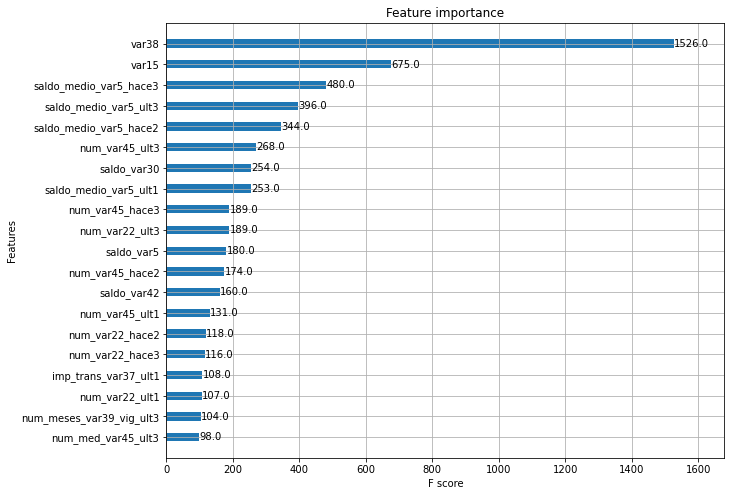

In [40]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
# XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순서이다.

In [44]:
from lightgbm import LGBMClassifier

# LightGBM으로 학습을 수행
lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='auc', eval_set =evals, verbose=True)

# ROC-AUC로 측정 -> XGBoost보다 학습 시간이 단축
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

In [47]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
# 튜닝 대상 num_leaves, max_depth, min_child_samples, subsample
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64], # 하나의 트리가 가질 수 있는 최대 리프 개수
         'max_depth':[128,160], # 최대 깊이
         'min_child_samples':[60,100], # min_samples_leaf -> 리프 노드가 되기 위한 최소한으로 필요한 레코드의 수
         'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
          eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC ACU : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

[34]	valid_0's auc: 0.87774	valid_0's binary_logloss: 0.122892	valid_1's auc: 0.838376	valid_1's binary_logloss: 0.139342
[35]	valid_0's auc: 0.878372	valid_0's binary_logloss: 0.122634	valid_1's auc: 0.838454	valid_1's binary_logloss: 0.13931
[36]	valid_0's auc: 0.879098	valid_0's binary_logloss: 0.122414	valid_1's auc: 0.838895	valid_1's binary_logloss: 0.13925
[37]	valid_0's auc: 0.879502	valid_0's binary_logloss: 0.122216	valid_1's auc: 0.838441	valid_1's binary_logloss: 0.139302
[38]	valid_0's auc: 0.880036	valid_0's binary_logloss: 0.121998	valid_1's auc: 0.838582	valid_1's binary_logloss: 0.139306
[39]	valid_0's auc: 0.880641	valid_0's binary_logloss: 0.121716	valid_1's auc: 0.838787	valid_1's binary_logloss: 0.139269
[40]	valid_0's auc: 0.881249	valid_0's binary_logloss: 0.121482	valid_1's auc: 0.838906	valid_1's binary_logloss: 0.139223
[41]	valid_0's auc: 0.881919	valid_0's binary_logloss: 0.121223	valid_1's auc: 0.838567	valid_1's binary_logloss: 0.13926
[1]	valid_0's auc: 0

[20]	valid_0's auc: 0.864799	valid_0's binary_logloss: 0.127654	valid_1's auc: 0.83435	valid_1's binary_logloss: 0.141148
[21]	valid_0's auc: 0.866472	valid_0's binary_logloss: 0.127165	valid_1's auc: 0.834176	valid_1's binary_logloss: 0.141041
[22]	valid_0's auc: 0.867055	valid_0's binary_logloss: 0.126777	valid_1's auc: 0.834173	valid_1's binary_logloss: 0.140887
[23]	valid_0's auc: 0.867726	valid_0's binary_logloss: 0.12643	valid_1's auc: 0.833577	valid_1's binary_logloss: 0.140909
[24]	valid_0's auc: 0.868612	valid_0's binary_logloss: 0.126061	valid_1's auc: 0.833336	valid_1's binary_logloss: 0.140824
[25]	valid_0's auc: 0.869224	valid_0's binary_logloss: 0.125753	valid_1's auc: 0.833428	valid_1's binary_logloss: 0.140793
[26]	valid_0's auc: 0.870183	valid_0's binary_logloss: 0.125414	valid_1's auc: 0.83333	valid_1's binary_logloss: 0.140724
[27]	valid_0's auc: 0.870926	valid_0's binary_logloss: 0.125123	valid_1's auc: 0.832503	valid_1's binary_logloss: 0.140772
[28]	valid_0's auc:

[21]	valid_0's auc: 0.866561	valid_0's binary_logloss: 0.127235	valid_1's auc: 0.839171	valid_1's binary_logloss: 0.140108
[22]	valid_0's auc: 0.867237	valid_0's binary_logloss: 0.12688	valid_1's auc: 0.839213	valid_1's binary_logloss: 0.13991
[23]	valid_0's auc: 0.867894	valid_0's binary_logloss: 0.126519	valid_1's auc: 0.839641	valid_1's binary_logloss: 0.139745
[24]	valid_0's auc: 0.868501	valid_0's binary_logloss: 0.126192	valid_1's auc: 0.840025	valid_1's binary_logloss: 0.139593
[25]	valid_0's auc: 0.869311	valid_0's binary_logloss: 0.125838	valid_1's auc: 0.839961	valid_1's binary_logloss: 0.139531
[26]	valid_0's auc: 0.870325	valid_0's binary_logloss: 0.125518	valid_1's auc: 0.839261	valid_1's binary_logloss: 0.139524
[27]	valid_0's auc: 0.871488	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.839671	valid_1's binary_logloss: 0.139365
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[29]	valid_0's auc: 

[38]	valid_0's auc: 0.89511	valid_0's binary_logloss: 0.115713	valid_1's auc: 0.827214	valid_1's binary_logloss: 0.14206
[39]	valid_0's auc: 0.895738	valid_0's binary_logloss: 0.115415	valid_1's auc: 0.82695	valid_1's binary_logloss: 0.142162
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011

[33]	valid_0's auc: 0.893164	valid_0's binary_logloss: 0.116978	valid_1's auc: 0.835865	valid_1's binary_logloss: 0.14041
[34]	valid_0's auc: 0.893848	valid_0's binary_logloss: 0.11662	valid_1's auc: 0.836021	valid_1's binary_logloss: 0.140353
[35]	valid_0's auc: 0.894232	valid_0's binary_logloss: 0.116323	valid_1's auc: 0.8359	valid_1's binary_logloss: 0.140396
[36]	valid_0's auc: 0.895003	valid_0's binary_logloss: 0.115986	valid_1's auc: 0.835855	valid_1's binary_logloss: 0.140416
[37]	valid_0's auc: 0.895898	valid_0's binary_logloss: 0.115609	valid_1's auc: 0.836185	valid_1's binary_logloss: 0.140369
[38]	valid_0's auc: 0.896459	valid_0's binary_logloss: 0.11527	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140443
[39]	valid_0's auc: 0.897377	valid_0's binary_logloss: 0.114873	valid_1's auc: 0.835638	valid_1's binary_logloss: 0.140474
[40]	valid_0's auc: 0.89776	valid_0's binary_logloss: 0.114588	valid_1's auc: 0.835639	valid_1's binary_logloss: 0.140491
[41]	valid_0's auc: 0.

[15]	valid_0's auc: 0.874839	valid_0's binary_logloss: 0.126147	valid_1's auc: 0.835363	valid_1's binary_logloss: 0.141464
[16]	valid_0's auc: 0.876399	valid_0's binary_logloss: 0.125331	valid_1's auc: 0.83478	valid_1's binary_logloss: 0.141245
[17]	valid_0's auc: 0.877465	valid_0's binary_logloss: 0.124655	valid_1's auc: 0.834621	valid_1's binary_logloss: 0.141028
[18]	valid_0's auc: 0.878935	valid_0's binary_logloss: 0.123944	valid_1's auc: 0.834165	valid_1's binary_logloss: 0.140935
[19]	valid_0's auc: 0.88046	valid_0's binary_logloss: 0.123313	valid_1's auc: 0.834629	valid_1's binary_logloss: 0.140738
[20]	valid_0's auc: 0.881517	valid_0's binary_logloss: 0.12269	valid_1's auc: 0.8347	valid_1's binary_logloss: 0.140611
[21]	valid_0's auc: 0.882464	valid_0's binary_logloss: 0.122095	valid_1's auc: 0.834656	valid_1's binary_logloss: 0.140487
[22]	valid_0's auc: 0.883744	valid_0's binary_logloss: 0.121504	valid_1's auc: 0.834562	valid_1's binary_logloss: 0.140328
[23]	valid_0's auc: 0

[53]	valid_0's auc: 0.904868	valid_0's binary_logloss: 0.110853	valid_1's auc: 0.834751	valid_1's binary_logloss: 0.14108
[54]	valid_0's auc: 0.905166	valid_0's binary_logloss: 0.110627	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.141282
[55]	valid_0's auc: 0.905665	valid_0's binary_logloss: 0.110375	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.141413
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845

[36]	valid_0's auc: 0.874973	valid_0's binary_logloss: 0.123651	valid_1's auc: 0.838114	valid_1's binary_logloss: 0.139148
[37]	valid_0's auc: 0.875657	valid_0's binary_logloss: 0.123447	valid_1's auc: 0.838519	valid_1's binary_logloss: 0.139109
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	v

[20]	valid_0's auc: 0.862574	valid_0's binary_logloss: 0.128458	valid_1's auc: 0.834949	valid_1's binary_logloss: 0.140968
[21]	valid_0's auc: 0.863262	valid_0's binary_logloss: 0.128069	valid_1's auc: 0.834616	valid_1's binary_logloss: 0.14086
[22]	valid_0's auc: 0.864655	valid_0's binary_logloss: 0.127684	valid_1's auc: 0.834363	valid_1's binary_logloss: 0.140766
[23]	valid_0's auc: 0.865247	valid_0's binary_logloss: 0.127349	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.140688
[24]	valid_0's auc: 0.865882	valid_0's binary_logloss: 0.12704	valid_1's auc: 0.833543	valid_1's binary_logloss: 0.14068
[25]	valid_0's auc: 0.867496	valid_0's binary_logloss: 0.126629	valid_1's auc: 0.834195	valid_1's binary_logloss: 0.140539
[26]	valid_0's auc: 0.867923	valid_0's binary_logloss: 0.126353	valid_1's auc: 0.834028	valid_1's binary_logloss: 0.140506
[27]	valid_0's auc: 0.868685	valid_0's binary_logloss: 0.126058	valid_1's auc: 0.834718	valid_1's binary_logloss: 0.140359
[28]	valid_0's auc:

[20]	valid_0's auc: 0.864083	valid_0's binary_logloss: 0.128369	valid_1's auc: 0.837509	valid_1's binary_logloss: 0.140794
[21]	valid_0's auc: 0.864747	valid_0's binary_logloss: 0.127959	valid_1's auc: 0.837888	valid_1's binary_logloss: 0.140626
[22]	valid_0's auc: 0.865769	valid_0's binary_logloss: 0.127562	valid_1's auc: 0.837811	valid_1's binary_logloss: 0.140487
[23]	valid_0's auc: 0.866657	valid_0's binary_logloss: 0.127217	valid_1's auc: 0.837884	valid_1's binary_logloss: 0.140328
[24]	valid_0's auc: 0.867293	valid_0's binary_logloss: 0.126875	valid_1's auc: 0.838481	valid_1's binary_logloss: 0.140215
[25]	valid_0's auc: 0.867983	valid_0's binary_logloss: 0.126562	valid_1's auc: 0.838239	valid_1's binary_logloss: 0.140124
[26]	valid_0's auc: 0.868559	valid_0's binary_logloss: 0.126248	valid_1's auc: 0.837903	valid_1's binary_logloss: 0.140092
[27]	valid_0's auc: 0.869394	valid_0's binary_logloss: 0.125936	valid_1's auc: 0.837493	valid_1's binary_logloss: 0.14006
[28]	valid_0's au

[26]	valid_0's auc: 0.883014	valid_0's binary_logloss: 0.121527	valid_1's auc: 0.829553	valid_1's binary_logloss: 0.14132
[27]	valid_0's auc: 0.884245	valid_0's binary_logloss: 0.121024	valid_1's auc: 0.829624	valid_1's binary_logloss: 0.14127
[28]	valid_0's auc: 0.885238	valid_0's binary_logloss: 0.12058	valid_1's auc: 0.829417	valid_1's binary_logloss: 0.141237
[29]	valid_0's auc: 0.88602	valid_0's binary_logloss: 0.120198	valid_1's auc: 0.82917	valid_1's binary_logloss: 0.141201
[30]	valid_0's auc: 0.88684	valid_0's binary_logloss: 0.119831	valid_1's auc: 0.82962	valid_1's binary_logloss: 0.141121
[31]	valid_0's auc: 0.887965	valid_0's binary_logloss: 0.119437	valid_1's auc: 0.83035	valid_1's binary_logloss: 0.14101
[32]	valid_0's auc: 0.88868	valid_0's binary_logloss: 0.119086	valid_1's auc: 0.82975	valid_1's binary_logloss: 0.141093
[33]	valid_0's auc: 0.889895	valid_0's binary_logloss: 0.118649	valid_1's auc: 0.829977	valid_1's binary_logloss: 0.141037
[34]	valid_0's auc: 0.89062

[13]	valid_0's auc: 0.868343	valid_0's binary_logloss: 0.129417	valid_1's auc: 0.833273	valid_1's binary_logloss: 0.142976
[14]	valid_0's auc: 0.86957	valid_0's binary_logloss: 0.128593	valid_1's auc: 0.833783	valid_1's binary_logloss: 0.142567
[15]	valid_0's auc: 0.871109	valid_0's binary_logloss: 0.127759	valid_1's auc: 0.834057	valid_1's binary_logloss: 0.142234
[16]	valid_0's auc: 0.872893	valid_0's binary_logloss: 0.126996	valid_1's auc: 0.835329	valid_1's binary_logloss: 0.141809
[17]	valid_0's auc: 0.874236	valid_0's binary_logloss: 0.12631	valid_1's auc: 0.834985	valid_1's binary_logloss: 0.141613
[18]	valid_0's auc: 0.875324	valid_0's binary_logloss: 0.125725	valid_1's auc: 0.834942	valid_1's binary_logloss: 0.141363
[19]	valid_0's auc: 0.876659	valid_0's binary_logloss: 0.125068	valid_1's auc: 0.835024	valid_1's binary_logloss: 0.141162
[20]	valid_0's auc: 0.877885	valid_0's binary_logloss: 0.124484	valid_1's auc: 0.835893	valid_1's binary_logloss: 0.140933
[21]	valid_0's auc

[26]	valid_0's auc: 0.883014	valid_0's binary_logloss: 0.121527	valid_1's auc: 0.829553	valid_1's binary_logloss: 0.14132
[27]	valid_0's auc: 0.884245	valid_0's binary_logloss: 0.121024	valid_1's auc: 0.829624	valid_1's binary_logloss: 0.14127
[28]	valid_0's auc: 0.885238	valid_0's binary_logloss: 0.12058	valid_1's auc: 0.829417	valid_1's binary_logloss: 0.141237
[29]	valid_0's auc: 0.88602	valid_0's binary_logloss: 0.120198	valid_1's auc: 0.82917	valid_1's binary_logloss: 0.141201
[30]	valid_0's auc: 0.88684	valid_0's binary_logloss: 0.119831	valid_1's auc: 0.82962	valid_1's binary_logloss: 0.141121
[31]	valid_0's auc: 0.887965	valid_0's binary_logloss: 0.119437	valid_1's auc: 0.83035	valid_1's binary_logloss: 0.14101
[32]	valid_0's auc: 0.88868	valid_0's binary_logloss: 0.119086	valid_1's auc: 0.82975	valid_1's binary_logloss: 0.141093
[33]	valid_0's auc: 0.889895	valid_0's binary_logloss: 0.118649	valid_1's auc: 0.829977	valid_1's binary_logloss: 0.141037
[34]	valid_0's auc: 0.89062

[14]	valid_0's auc: 0.86957	valid_0's binary_logloss: 0.128593	valid_1's auc: 0.833783	valid_1's binary_logloss: 0.142567
[15]	valid_0's auc: 0.871109	valid_0's binary_logloss: 0.127759	valid_1's auc: 0.834057	valid_1's binary_logloss: 0.142234
[16]	valid_0's auc: 0.872893	valid_0's binary_logloss: 0.126996	valid_1's auc: 0.835329	valid_1's binary_logloss: 0.141809
[17]	valid_0's auc: 0.874236	valid_0's binary_logloss: 0.12631	valid_1's auc: 0.834985	valid_1's binary_logloss: 0.141613
[18]	valid_0's auc: 0.875324	valid_0's binary_logloss: 0.125725	valid_1's auc: 0.834942	valid_1's binary_logloss: 0.141363
[19]	valid_0's auc: 0.876659	valid_0's binary_logloss: 0.125068	valid_1's auc: 0.835024	valid_1's binary_logloss: 0.141162
[20]	valid_0's auc: 0.877885	valid_0's binary_logloss: 0.124484	valid_1's auc: 0.835893	valid_1's binary_logloss: 0.140933
[21]	valid_0's auc: 0.879121	valid_0's binary_logloss: 0.12391	valid_1's auc: 0.837029	valid_1's binary_logloss: 0.140651
[22]	valid_0's auc:

[29]	valid_0's auc: 0.873397	valid_0's binary_logloss: 0.124495	valid_1's auc: 0.833175	valid_1's binary_logloss: 0.140604
[30]	valid_0's auc: 0.87475	valid_0's binary_logloss: 0.12417	valid_1's auc: 0.833614	valid_1's binary_logloss: 0.140497
[31]	valid_0's auc: 0.875407	valid_0's binary_logloss: 0.12389	valid_1's auc: 0.833706	valid_1's binary_logloss: 0.140428
[32]	valid_0's auc: 0.876136	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.833458	valid_1's binary_logloss: 0.140448
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123421	valid_1's auc: 0.832965	valid_1's binary_logloss: 0.140498
[34]	valid_0's auc: 0.877224	valid_0's binary_logloss: 0.123219	valid_1's auc: 0.832659	valid_1's binary_logloss: 0.140537
[35]	valid_0's auc: 0.877898	valid_0's binary_logloss: 0.122947	valid_1's auc: 0.832787	valid_1's binary_logloss: 0.140536
[36]	valid_0's auc: 0.878334	valid_0's binary_logloss: 0.122724	valid_1's auc: 0.832724	valid_1's binary_logloss: 0.14053
[37]	valid_0's auc: 

[20]	valid_0's auc: 0.865797	valid_0's binary_logloss: 0.127679	valid_1's auc: 0.838788	valid_1's binary_logloss: 0.140332
[21]	valid_0's auc: 0.866561	valid_0's binary_logloss: 0.127235	valid_1's auc: 0.839171	valid_1's binary_logloss: 0.140108
[22]	valid_0's auc: 0.867237	valid_0's binary_logloss: 0.12688	valid_1's auc: 0.839213	valid_1's binary_logloss: 0.13991
[23]	valid_0's auc: 0.867894	valid_0's binary_logloss: 0.126519	valid_1's auc: 0.839641	valid_1's binary_logloss: 0.139745
[24]	valid_0's auc: 0.868501	valid_0's binary_logloss: 0.126192	valid_1's auc: 0.840025	valid_1's binary_logloss: 0.139593
[25]	valid_0's auc: 0.869311	valid_0's binary_logloss: 0.125838	valid_1's auc: 0.839961	valid_1's binary_logloss: 0.139531
[26]	valid_0's auc: 0.870325	valid_0's binary_logloss: 0.125518	valid_1's auc: 0.839261	valid_1's binary_logloss: 0.139524
[27]	valid_0's auc: 0.871488	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.839671	valid_1's binary_logloss: 0.139365
[28]	valid_0's auc

[37]	valid_0's auc: 0.878762	valid_0's binary_logloss: 0.122514	valid_1's auc: 0.832581	valid_1's binary_logloss: 0.140533
[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.84969

[35]	valid_0's auc: 0.87822	valid_0's binary_logloss: 0.122873	valid_1's auc: 0.8389	valid_1's binary_logloss: 0.139187
[36]	valid_0's auc: 0.878932	valid_0's binary_logloss: 0.12259	valid_1's auc: 0.838921	valid_1's binary_logloss: 0.139194
[37]	valid_0's auc: 0.879842	valid_0's binary_logloss: 0.12233	valid_1's auc: 0.839133	valid_1's binary_logloss: 0.139161
[38]	valid_0's auc: 0.880497	valid_0's binary_logloss: 0.12208	valid_1's auc: 0.838975	valid_1's binary_logloss: 0.139143
[39]	valid_0's auc: 0.881056	valid_0's binary_logloss: 0.121827	valid_1's auc: 0.839037	valid_1's binary_logloss: 0.139138
[40]	valid_0's auc: 0.881604	valid_0's binary_logloss: 0.121603	valid_1's auc: 0.839204	valid_1's binary_logloss: 0.139119
[41]	valid_0's auc: 0.882159	valid_0's binary_logloss: 0.121355	valid_1's auc: 0.839277	valid_1's binary_logloss: 0.139091
[42]	valid_0's auc: 0.882757	valid_0's binary_logloss: 0.121116	valid_1's auc: 0.838964	valid_1's binary_logloss: 0.139133
[43]	valid_0's auc: 0.

[16]	valid_0's auc: 0.876399	valid_0's binary_logloss: 0.125331	valid_1's auc: 0.83478	valid_1's binary_logloss: 0.141245
[17]	valid_0's auc: 0.877465	valid_0's binary_logloss: 0.124655	valid_1's auc: 0.834621	valid_1's binary_logloss: 0.141028
[18]	valid_0's auc: 0.878935	valid_0's binary_logloss: 0.123944	valid_1's auc: 0.834165	valid_1's binary_logloss: 0.140935
[19]	valid_0's auc: 0.88046	valid_0's binary_logloss: 0.123313	valid_1's auc: 0.834629	valid_1's binary_logloss: 0.140738
[20]	valid_0's auc: 0.881517	valid_0's binary_logloss: 0.12269	valid_1's auc: 0.8347	valid_1's binary_logloss: 0.140611
[21]	valid_0's auc: 0.882464	valid_0's binary_logloss: 0.122095	valid_1's auc: 0.834656	valid_1's binary_logloss: 0.140487
[22]	valid_0's auc: 0.883744	valid_0's binary_logloss: 0.121504	valid_1's auc: 0.834562	valid_1's binary_logloss: 0.140328
[23]	valid_0's auc: 0.885301	valid_0's binary_logloss: 0.12091	valid_1's auc: 0.835278	valid_1's binary_logloss: 0.140199
[24]	valid_0's auc: 0.

[52]	valid_0's auc: 0.90467	valid_0's binary_logloss: 0.111111	valid_1's auc: 0.835057	valid_1's binary_logloss: 0.140993
[53]	valid_0's auc: 0.904868	valid_0's binary_logloss: 0.110853	valid_1's auc: 0.834751	valid_1's binary_logloss: 0.14108
[54]	valid_0's auc: 0.905166	valid_0's binary_logloss: 0.110627	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.141282
[55]	valid_0's auc: 0.905665	valid_0's binary_logloss: 0.110375	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.141413
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	

[27]	valid_0's auc: 0.889589	valid_0's binary_logloss: 0.119012	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.139843
[28]	valid_0's auc: 0.890552	valid_0's binary_logloss: 0.118602	valid_1's auc: 0.836524	valid_1's binary_logloss: 0.139871
[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc: 0.891982	valid_0's binary_logloss: 0.117805	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.139937
[31]	valid_0's auc: 0.893185	valid_0's binary_logloss: 0.117392	valid_1's auc: 0.836384	valid_1's binary_logloss: 0.13992
[32]	valid_0's auc: 0.894065	valid_0's binary_logloss: 0.117017	valid_1's auc: 0.836341	valid_1's binary_logloss: 0.139888
[33]	valid_0's auc: 0.894791	valid_0's binary_logloss: 0.116671	valid_1's auc: 0.836753	valid_1's binary_logloss: 0.139812
[34]	valid_0's auc: 0.895313	valid_0's binary_logloss: 0.116321	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.139826
[35]	valid_0's au

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

[32]	valid_0's auc: 0.872606	valid_0's binary_logloss: 0.124561	valid_1's auc: 0.837662	valid_1's binary_logloss: 0.139274
[33]	valid_0's auc: 0.873337	valid_0's binary_logloss: 0.124346	valid_1's auc: 0.837661	valid_1's binary_logloss: 0.139284
[34]	valid_0's auc: 0.873965	valid_0's binary_logloss: 0.124108	valid_1's auc: 0.837639	valid_1's binary_logloss: 0.139263
[35]	valid_0's auc: 0.87457	valid_0's binary_logloss: 0.123857	valid_1's auc: 0.838159	valid_1's binary_logloss: 0.139137
[36]	valid_0's auc: 0.874973	valid_0's binary_logloss: 0.123651	valid_1's auc: 0.838114	valid_1's binary_logloss: 0.139148
[37]	valid_0's auc: 0.875657	valid_0's binary_logloss: 0.123447	valid_1's auc: 0.838519	valid_1's binary_logloss: 0.139109
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

[37]	valid_0's auc: 0.875657	valid_0's binary_logloss: 0.123447	valid_1's auc: 0.838519	valid_1's binary_logloss: 0.139109
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	va

[16]	valid_0's auc: 0.871816	valid_0's binary_logloss: 0.126943	valid_1's auc: 0.83329	valid_1's binary_logloss: 0.142022
[17]	valid_0's auc: 0.872964	valid_0's binary_logloss: 0.126266	valid_1's auc: 0.83279	valid_1's binary_logloss: 0.141891
[18]	valid_0's auc: 0.874047	valid_0's binary_logloss: 0.125646	valid_1's auc: 0.831917	valid_1's binary_logloss: 0.141748
[19]	valid_0's auc: 0.875336	valid_0's binary_logloss: 0.125072	valid_1's auc: 0.831274	valid_1's binary_logloss: 0.141658
[20]	valid_0's auc: 0.876959	valid_0's binary_logloss: 0.124484	valid_1's auc: 0.831275	valid_1's binary_logloss: 0.141511
[21]	valid_0's auc: 0.878049	valid_0's binary_logloss: 0.123928	valid_1's auc: 0.830813	valid_1's binary_logloss: 0.141459
[22]	valid_0's auc: 0.878905	valid_0's binary_logloss: 0.123447	valid_1's auc: 0.83012	valid_1's binary_logloss: 0.141449
[23]	valid_0's auc: 0.879827	valid_0's binary_logloss: 0.12295	valid_1's auc: 0.829554	valid_1's binary_logloss: 0.141492
[24]	valid_0's auc: 

[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

[11]	valid_0's auc: 0.864277	valid_0's binary_logloss: 0.13126	valid_1's auc: 0.834957	valid_1's binary_logloss: 0.144152
[12]	valid_0's auc: 0.865572	valid_0's binary_logloss: 0.130304	valid_1's auc: 0.833693	valid_1's binary_logloss: 0.143697
[13]	valid_0's auc: 0.867519	valid_0's binary_logloss: 0.129385	valid_1's auc: 0.833158	valid_1's binary_logloss: 0.143184
[14]	valid_0's auc: 0.869354	valid_0's binary_logloss: 0.128524	valid_1's auc: 0.833598	valid_1's binary_logloss: 0.142668
[15]	valid_0's auc: 0.870553	valid_0's binary_logloss: 0.127746	valid_1's auc: 0.833467	valid_1's binary_logloss: 0.142302
[16]	valid_0's auc: 0.871816	valid_0's binary_logloss: 0.126943	valid_1's auc: 0.83329	valid_1's binary_logloss: 0.142022
[17]	valid_0's auc: 0.872964	valid_0's binary_logloss: 0.126266	valid_1's auc: 0.83279	valid_1's binary_logloss: 0.141891
[18]	valid_0's auc: 0.874047	valid_0's binary_logloss: 0.125646	valid_1's auc: 0.831917	valid_1's binary_logloss: 0.141748
[19]	valid_0's auc:

[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

[17]	training's auc: 0.865605	training's binary_logloss: 0.128901	valid_1's auc: 0.840563	valid_1's binary_logloss: 0.140752
[18]	training's auc: 0.866635	training's binary_logloss: 0.128334	valid_1's auc: 0.839571	valid_1's binary_logloss: 0.140569
[19]	training's auc: 0.867769	training's binary_logloss: 0.127836	valid_1's auc: 0.839656	valid_1's binary_logloss: 0.14032
[20]	training's auc: 0.868754	training's binary_logloss: 0.127334	valid_1's auc: 0.839451	valid_1's binary_logloss: 0.140153
[21]	training's auc: 0.86983	training's binary_logloss: 0.12692	valid_1's auc: 0.839806	valid_1's binary_logloss: 0.139937
[22]	training's auc: 0.870884	training's binary_logloss: 0.126484	valid_1's auc: 0.839529	valid_1's binary_logloss: 0.13983
[23]	training's auc: 0.871649	training's binary_logloss: 0.126082	valid_1's auc: 0.839217	valid_1's binary_logloss: 0.139727
[24]	training's auc: 0.872461	training's binary_logloss: 0.125727	valid_1's auc: 0.838771	valid_1's binary_logloss: 0.139684
[25]

In [50]:
# 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과를 도출
lgbm_clf = LGBMClassifier(n_estimators =1000, num_leaves=32 , sumbsample=0.8, min_child_samples=100, max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	valid_0's auc: 0.841108	valid_0's binary_logloss: 0